In [1]:
import numpy as np
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import layers
from keras.utils import load_img, img_to_array
import keras.backend as K
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def create_discriminator(img_shape):
    init = RandomNormal(stddev= 0.02)
    
    in_src_img = layers.Input(img_shape)
    in_target_img = layers.Input(img_shape)
    
    merged = layers.Concatenate()([in_src_img, in_target_img])
    
    d = layers.Conv2D(64, 4, strides= 2, padding= 'same', kernel_initializer= init)(merged)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(128, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(256, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(512, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(512, 4, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(1, 4, padding= 'same', kernel_initializer= init)(d)
    d = layers.Activation('sigmoid')(d)
    
    model = Model([in_src_img, in_target_img], d)
    
    opt = Adam(0.0002, 0.5)
    model.compile(opt, loss= 'binary_crossentropy', loss_weights= [0.5])
    
    return model

In [3]:
def encoder(layer_in, n_filters, batch_norm= True):
    init = RandomNormal(stddev= 0.02)
    
    g = layers.Conv2D(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    if batch_norm:
        g = layers.BatchNormalization()(g, training= True)
    g = layers.LeakyReLU(alpha= 0.2)(g)        
    return g

In [4]:
def decoder(layer_in, skip_in, n_filters, dropout= True):
    init= RandomNormal(stddev= 0.02)
    
    g = layers.Conv2DTranspose(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    g = layers.BatchNormalization()(g, training= True)
    if dropout:
        g = layers.Dropout(0.5)(g, training= True)
    g = layers.Concatenate()([g, skip_in])
    g = layers.Activation('relu')(g)
    return g

In [5]:
def create_generator(img_shape= (256, 256, 3)):
    init = RandomNormal(stddev= 0.02)
    
    in_img = layers.Input(img_shape)
    
    e1 = encoder(in_img, 64, batch_norm= False)
    e2 = encoder(e1, 128)
    e3 = encoder(e2, 256)
    e4 = encoder(e3, 512)
    e5 = encoder(e4, 512)
    e6 = encoder(e5, 512)
    e7 = encoder(e6, 512)
    
    b = layers.Conv2D(512, 4, strides= 2, padding='same', kernel_initializer=init)(e7)
    b = layers.Activation('relu')(b)
    
    d1 = decoder(b, e7, 512)
    d2 = decoder(d1, e6, 512)
    d3 = decoder(d2, e5, 512)
    d4 = decoder(d3, e4, 512, dropout= False)
    d5 = decoder(d4, e3, 256, dropout= False)
    d6 = decoder(d5, e2, 128, dropout= False)
    d7 = decoder(d6, e1, 64, dropout= False)
    
    out_img = layers.Conv2DTranspose(img_shape[2], 4, strides= 2, padding= 'same', kernel_initializer= init)(d7)
    out_img = layers.Activation('tanh')(out_img)
    
    model = Model(in_img, out_img)
    return model

In [6]:
def create_gan(generator, discriminator, img_shape):
    
    for layer in discriminator.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    
    in_src = layers.Input(img_shape)
    
    gen_out = generator(in_src)
    dis_out = discriminator([in_src, gen_out])
    
    model = Model(in_src, [dis_out, gen_out])
    
    opt = Adam(0.0002, 0.5)
    model.compile(opt, loss= ['binary_crossentropy', 'mae'], loss_weights= [1, 100])
    return model

In [7]:
def gen_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    idx = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[idx], trainB[idx]
    
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

In [8]:
def gen_fake_samples(generator, samples, patch_shape):
    X = generator.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [9]:
def performance(step, generator, dataset, n_samples= 3):
    [X_real_A, X_real_B], _ = gen_real_samples(dataset, n_samples, 1)
    X_fake_B, _ = gen_fake_samples(generator, X_real_A, 1)
    
    X_real_A = (X_real_A + 1)/2.0
    X_real_B = (X_real_B + 1)/2.0
    X_fake_B = (X_fake_B + 1)/2.0
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_real_A[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_real_B[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_fake_B[i])
    plt.show()

In [10]:
def train(generator, discriminator, gan, dataset, epochs= 100, batch= 1):
    n_patch = discriminator.output_shape[1]
    
    trainA, trainB = dataset
    
    batch_per_epoch = int(len(trainA)/batch)
    n_steps = batch_per_epoch * epochs
    
    for i in range(n_steps):
        [X_realA, X_realB], y_real = gen_real_samples(dataset, batch, n_patch)
        X_fakeB, y_fake = gen_fake_samples(generator, X_realA, n_patch)
        
        d_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = discriminator.train_on_batch([X_realA, X_fakeB], y_fake)
        
        g_loss, _, _ = gan.train_on_batch(X_realA, [y_real, X_realB])
        
        print(f'dl1 : {d_loss1}, dl2 : {d_loss2}, gl: {g_loss}')
        
        if (i + 1) % (batch_per_epoch * 10) == 0:
            performance(i, generator, dataset)

In [11]:
img_sample = mpimg.imread('/kaggle/input/cityscapes/cityscapes/train/1.jpg')

In [12]:
img_sample.shape

(256, 512, 3)

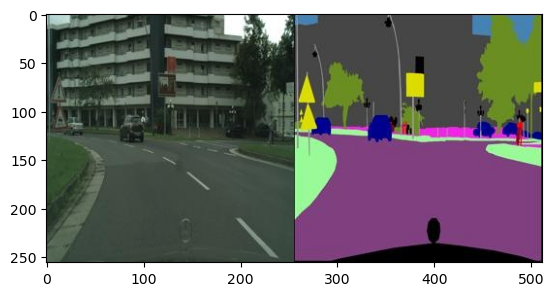

In [13]:
plt.imshow(img_sample)
plt.show()

In [14]:
def get_images(path, img_shape= (256, 512)):
    src_list, tar_list = list(), list()
    
    # Get 100 images else it will take forever to train
    count = 0
    for f in glob.glob(path):
        if count == 10:
            break
        pxl = load_img(f, target_size= img_shape)
        pxl = img_to_array(pxl)
        
        scape_img, mask_img = pxl[:, :256], pxl[:, 256:]
        
        src_list.append(scape_img)
        tar_list.append(mask_img)
        
        count += 1
        
    return[np.asarray(src_list), np.asarray(tar_list)]
        

In [15]:
path = '/kaggle/input/cityscapes/cityscapes/train/*.jpg'

In [16]:
[src, tar] = get_images(path)

In [17]:
src.shape, tar.shape

((10, 256, 256, 3), (10, 256, 256, 3))

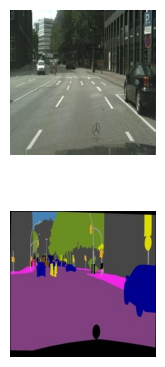

In [18]:
plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(src[0].astype('uint8'))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.imshow(tar[0].astype('uint8'))

plt.show()

In [19]:
def proc(data):
    X1, X2 = data[0], data[1]
    
    X1 = (X1 - 127.5)/127.5
    X2 = (X2 - 127.5)/127.5
    
    return [X1, X2]

In [20]:
data = [src, tar]
dataset = proc(data)

In [21]:
dataset[0][0]

array([[[-1.        , -0.96862745, -1.        ],
        [-0.8039216 , -0.75686276, -0.7882353 ],
        [-0.5529412 , -0.5058824 , -0.5372549 ],
        ...,
        [-0.8901961 , -0.81960785, -0.827451  ],
        [-0.84313726, -0.7647059 , -0.7490196 ],
        [-0.84313726, -0.7647059 , -0.75686276]],

       [[-1.        , -0.96862745, -1.        ],
        [-0.78039217, -0.73333335, -0.7647059 ],
        [-0.5372549 , -0.49019608, -0.52156866],
        ...,
        [-0.8901961 , -0.81960785, -0.827451  ],
        [-0.84313726, -0.7647059 , -0.7490196 ],
        [-0.8352941 , -0.75686276, -0.7490196 ]],

       [[-1.        , -0.9764706 , -1.        ],
        [-0.7647059 , -0.7176471 , -0.7490196 ],
        [-0.5294118 , -0.48235294, -0.5137255 ],
        ...,
        [-0.88235295, -0.8117647 , -0.81960785],
        [-0.827451  , -0.7490196 , -0.73333335],
        [-0.827451  , -0.7490196 , -0.7411765 ]],

       ...,

       [[-0.08235294, -0.01960784, -0.10588235],
        [-0

In [22]:
img_shape = src.shape[1:]

In [23]:
img_shape

(256, 256, 3)

In [24]:
generator = create_generator(img_shape)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [25]:
discriminator = create_discriminator(img_shape)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [26]:
gan = create_gan(generator, discriminator, img_shape)
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 256, 256, 3)  54429315    ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 16, 16, 1)    6968257     ['input_4[0][0]',                
                                                                  'model[0][0]']                  
                                                                                            

In [27]:
K.clear_session()

2023-07-27 12:48:47.437689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 7s 7s/step


2023-07-27 12:49:01.117176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


dl1 : 0.7730525732040405, dl2 : 0.4603707790374756, gl: 46.16925048828125
1/1 [==============================] - 0s 21ms/step
dl1 : 0.7574968338012695, dl2 : 0.584394633769989, gl: 43.956363677978516
1/1 [==============================] - 0s 22ms/step
dl1 : 0.5412206053733826, dl2 : 0.6787679195404053, gl: 42.12078857421875
1/1 [==============================] - 0s 22ms/step
dl1 : 0.4407768249511719, dl2 : 0.45454105734825134, gl: 43.3864631652832
1/1 [==============================] - 0s 20ms/step
dl1 : 0.2770926356315613, dl2 : 0.3468565046787262, gl: 38.37306594848633
1/1 [==============================] - 0s 23ms/step
dl1 : 0.4555678367614746, dl2 : 0.392780065536499, gl: 37.383384704589844
1/1 [==============================] - 0s 21ms/step
dl1 : 0.33552616834640503, dl2 : 0.49743151664733887, gl: 34.77590560913086
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3356524109840393, dl2 : 0.3721463680267334, gl: 38.47533416748047
1/1 [==============================] - 0s 

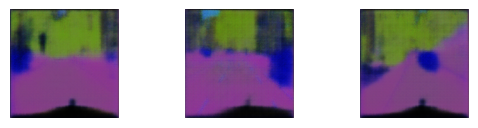

1/1 [==============================] - 0s 22ms/step
dl1 : 0.04027067869901657, dl2 : 0.2705773711204529, gl: 16.817180633544922
1/1 [==============================] - 0s 20ms/step
dl1 : 0.09063924103975296, dl2 : 0.08197560161352158, gl: 22.0384464263916
1/1 [==============================] - 0s 20ms/step
dl1 : 0.08342266827821732, dl2 : 0.14840760827064514, gl: 17.977148056030273
1/1 [==============================] - 0s 20ms/step
dl1 : 0.09238366782665253, dl2 : 0.02388351783156395, gl: 23.46961212158203
1/1 [==============================] - 0s 20ms/step
dl1 : 0.10584870725870132, dl2 : 0.039740659296512604, gl: 21.762218475341797
1/1 [==============================] - 0s 27ms/step
dl1 : 0.25410470366477966, dl2 : 0.08067689090967178, gl: 17.124034881591797
1/1 [==============================] - 0s 22ms/step
dl1 : 0.48598814010620117, dl2 : 0.520117998123169, gl: 13.209266662597656
1/1 [==============================] - 0s 24ms/step
dl1 : 0.03196049481630325, dl2 : 0.126229375600814

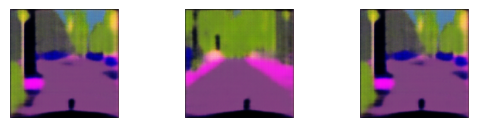

1/1 [==============================] - 0s 21ms/step
dl1 : 0.40172079205513, dl2 : 0.30311208963394165, gl: 14.227461814880371
1/1 [==============================] - 0s 22ms/step
dl1 : 0.15161295235157013, dl2 : 0.19988387823104858, gl: 12.91729736328125
1/1 [==============================] - 0s 21ms/step
dl1 : 0.24773062765598297, dl2 : 0.6061810255050659, gl: 12.514551162719727
1/1 [==============================] - 0s 28ms/step
dl1 : 0.44251883029937744, dl2 : 0.2880590856075287, gl: 11.366851806640625
1/1 [==============================] - 0s 21ms/step
dl1 : 0.39054858684539795, dl2 : 0.265385240316391, gl: 13.304266929626465
1/1 [==============================] - 0s 23ms/step
dl1 : 0.29963740706443787, dl2 : 0.3327780067920685, gl: 11.370528221130371
1/1 [==============================] - 0s 21ms/step
dl1 : 0.26184964179992676, dl2 : 0.40679094195365906, gl: 10.710633277893066
1/1 [==============================] - 0s 19ms/step
dl1 : 0.2988690733909607, dl2 : 0.21989206969738007, g

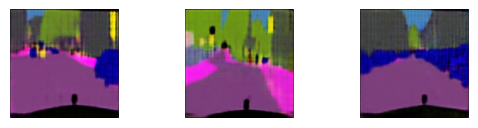

1/1 [==============================] - 0s 21ms/step
dl1 : 0.7538709044456482, dl2 : 0.29606103897094727, gl: 8.106892585754395
1/1 [==============================] - 0s 20ms/step
dl1 : 0.34583231806755066, dl2 : 0.5001790523529053, gl: 8.075074195861816
1/1 [==============================] - 0s 23ms/step
dl1 : 0.13641071319580078, dl2 : 0.21849632263183594, gl: 10.529061317443848
1/1 [==============================] - 0s 23ms/step
dl1 : 0.47852766513824463, dl2 : 0.3396472632884979, gl: 8.040533065795898
1/1 [==============================] - 0s 21ms/step
dl1 : 0.20603910088539124, dl2 : 0.26375699043273926, gl: 9.32494068145752
1/1 [==============================] - 0s 23ms/step
dl1 : 0.10957540571689606, dl2 : 0.22847884893417358, gl: 11.168298721313477
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3739502429962158, dl2 : 0.23086348176002502, gl: 9.8448486328125
1/1 [==============================] - 0s 22ms/step
dl1 : 0.36396515369415283, dl2 : 0.35036590695381165, gl:

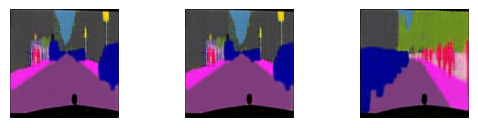

1/1 [==============================] - 0s 23ms/step
dl1 : 0.516435444355011, dl2 : 0.273070752620697, gl: 6.428731918334961
1/1 [==============================] - 0s 21ms/step
dl1 : 0.2737415134906769, dl2 : 0.30097123980522156, gl: 8.241988182067871
1/1 [==============================] - 0s 19ms/step
dl1 : 0.2175026834011078, dl2 : 0.28676387667655945, gl: 7.718206882476807
1/1 [==============================] - 0s 20ms/step
dl1 : 0.45592477917671204, dl2 : 0.30041661858558655, gl: 7.278199195861816
1/1 [==============================] - 0s 21ms/step
dl1 : 0.25531721115112305, dl2 : 0.329070508480072, gl: 6.310268402099609
1/1 [==============================] - 0s 22ms/step
dl1 : 0.21218575537204742, dl2 : 0.28071218729019165, gl: 5.9976725578308105
1/1 [==============================] - 0s 21ms/step
dl1 : 0.23875093460083008, dl2 : 0.4168148636817932, gl: 7.505169868469238
1/1 [==============================] - 0s 22ms/step
dl1 : 0.4343896806240082, dl2 : 0.2914366126060486, gl: 6.60

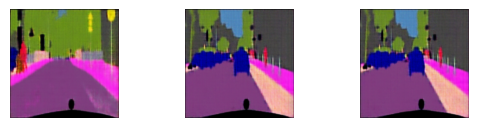

1/1 [==============================] - 0s 26ms/step
dl1 : 0.3512476980686188, dl2 : 0.29460275173187256, gl: 6.655776023864746
1/1 [==============================] - 0s 24ms/step
dl1 : 0.3026711940765381, dl2 : 0.3893906772136688, gl: 6.175311088562012
1/1 [==============================] - 0s 27ms/step
dl1 : 0.2672010660171509, dl2 : 0.31889694929122925, gl: 7.594151973724365
1/1 [==============================] - 0s 29ms/step
dl1 : 0.4022640287876129, dl2 : 0.33171582221984863, gl: 6.210910797119141
1/1 [==============================] - 0s 26ms/step
dl1 : 0.3976355493068695, dl2 : 0.35353222489356995, gl: 6.039609432220459
1/1 [==============================] - 0s 25ms/step
dl1 : 0.20987612009048462, dl2 : 0.25835055112838745, gl: 6.585065841674805
1/1 [==============================] - 0s 26ms/step
dl1 : 0.37764984369277954, dl2 : 0.30511778593063354, gl: 6.713322162628174
1/1 [==============================] - 0s 24ms/step
dl1 : 0.3288350999355316, dl2 : 0.38467904925346375, gl: 6

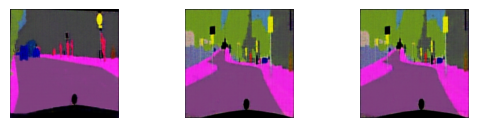

1/1 [==============================] - 0s 21ms/step
dl1 : 0.23713991045951843, dl2 : 0.3007177710533142, gl: 5.576150894165039
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3689573109149933, dl2 : 0.29485929012298584, gl: 5.837998867034912
1/1 [==============================] - 0s 21ms/step
dl1 : 0.30381786823272705, dl2 : 0.3885130286216736, gl: 5.742327690124512
1/1 [==============================] - 0s 23ms/step
dl1 : 0.2043425440788269, dl2 : 0.24259549379348755, gl: 5.972909450531006
1/1 [==============================] - 0s 21ms/step
dl1 : 0.35232922434806824, dl2 : 0.33614277839660645, gl: 5.027293682098389
1/1 [==============================] - 0s 21ms/step
dl1 : 0.2955535352230072, dl2 : 0.3507545590400696, gl: 4.757338047027588
1/1 [==============================] - 0s 19ms/step
dl1 : 0.3779086470603943, dl2 : 0.3097161054611206, gl: 5.50242280960083
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3541144132614136, dl2 : 0.35422399640083313, gl: 5.45

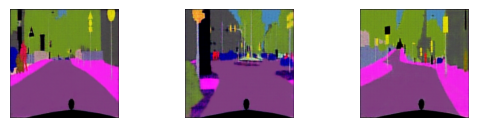

1/1 [==============================] - 0s 21ms/step
dl1 : 0.23449915647506714, dl2 : 0.27864331007003784, gl: 6.294860363006592
1/1 [==============================] - 0s 20ms/step
dl1 : 0.34894412755966187, dl2 : 0.2690676748752594, gl: 5.6315202713012695
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3193526566028595, dl2 : 0.29743438959121704, gl: 5.1900248527526855
1/1 [==============================] - 0s 20ms/step
dl1 : 0.2155437469482422, dl2 : 0.221064031124115, gl: 7.653862476348877
1/1 [==============================] - 0s 20ms/step
dl1 : 0.25130727887153625, dl2 : 0.33959510922431946, gl: 6.029258728027344
1/1 [==============================] - 0s 20ms/step
dl1 : 0.2642613351345062, dl2 : 0.2684231400489807, gl: 6.313889980316162
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3820757269859314, dl2 : 0.3577973246574402, gl: 5.450981140136719
1/1 [==============================] - 0s 21ms/step
dl1 : 0.21017131209373474, dl2 : 0.31077897548675537, gl: 5

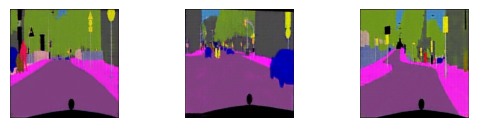

1/1 [==============================] - 0s 21ms/step
dl1 : 0.22763454914093018, dl2 : 0.3052275776863098, gl: 5.166944980621338
1/1 [==============================] - 0s 20ms/step
dl1 : 0.39252805709838867, dl2 : 0.27971237897872925, gl: 4.819916725158691
1/1 [==============================] - 0s 22ms/step
dl1 : 0.2880879044532776, dl2 : 0.2715471386909485, gl: 5.154944896697998
1/1 [==============================] - 0s 22ms/step
dl1 : 0.14067381620407104, dl2 : 0.21897952258586884, gl: 5.3063764572143555
1/1 [==============================] - 0s 21ms/step
dl1 : 0.24295222759246826, dl2 : 0.26407918334007263, gl: 6.459555625915527
1/1 [==============================] - 0s 20ms/step
dl1 : 0.31887292861938477, dl2 : 0.28273171186447144, gl: 5.025388240814209
1/1 [==============================] - 0s 21ms/step
dl1 : 0.26898080110549927, dl2 : 0.27896639704704285, gl: 5.170889854431152
1/1 [==============================] - 0s 24ms/step
dl1 : 0.3297881782054901, dl2 : 0.30977851152420044, g

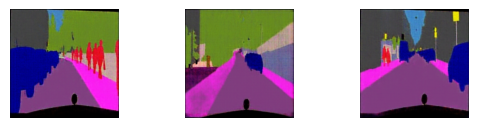

1/1 [==============================] - 0s 21ms/step
dl1 : 0.36117520928382874, dl2 : 0.30637484788894653, gl: 4.637776851654053
1/1 [==============================] - 0s 22ms/step
dl1 : 0.2822903096675873, dl2 : 0.3276943862438202, gl: 5.094866752624512
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3211836814880371, dl2 : 0.3211098611354828, gl: 6.299383163452148
1/1 [==============================] - 0s 22ms/step
dl1 : 0.13473105430603027, dl2 : 0.1625363677740097, gl: 6.286672592163086
1/1 [==============================] - 0s 24ms/step
dl1 : 0.307754248380661, dl2 : 0.2857745885848999, gl: 4.718890190124512
1/1 [==============================] - 0s 32ms/step
dl1 : 0.2155800610780716, dl2 : 0.19484224915504456, gl: 6.470807075500488
1/1 [==============================] - 0s 22ms/step
dl1 : 0.22147610783576965, dl2 : 0.2630426287651062, gl: 5.453831672668457
1/1 [==============================] - 0s 20ms/step
dl1 : 0.2402482032775879, dl2 : 0.2565477192401886, gl: 5.0151

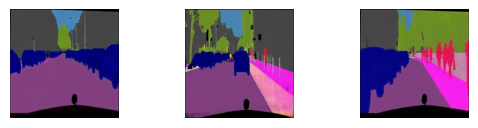

In [28]:
train(generator, discriminator, gan, dataset, epochs= 100)

In [29]:
def plot_images(src, gen, tar):
    images = np.vstack((src, gen, tar))  
    images = (images + 1)/2.0
    
    titles = ['Source', 'Generated', 'Expected']
    
    for i in range(len(images)):
        plt.subplot(1, 3, i + 1)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

1/1 [==============================] - 0s 21ms/step


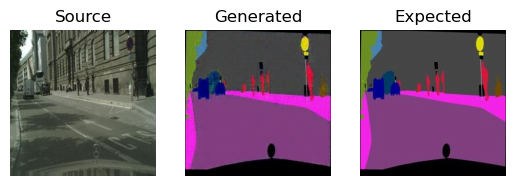

In [30]:
[X1, X2] = dataset
idx = np.random.randint(0, len(X1), 1)

src, tar = X1[idx], X2[idx]
gen = generator.predict(src)

plot_images(src, gen, tar)